<a href="https://colab.research.google.com/github/manesioz/Bioinformatics-Challenges/blob/master/Temperature_Data_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install datalab 

from google.cloud import bigquery
from google.colab import auth

import branca
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import IPython
import folium 
from folium.plugins import HeatMap
from folium import IFrame
import datetime
import numpy as np
import pandas as pd

import datalab.bigquery as bq
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]

In [0]:
_ = auth.authenticate_user()
client = bigquery.Client(project='geotab-bi')
job_config = bigquery.QueryJobConfig()
job_config.use_legacy_sql = False

### Problem 

As you can see below, there are *many* instances where MinTemperature = MaxTemperature despite there being many Devices and Records for some given Make/Model/Year/Engine combination on a given day. The following queries and visualizations will attempt to narrow down the scope of the issue.    

In [0]:
#This is the raw data - use this query as a starting point
SQL = """
CREATE TEMP FUNCTION f_GeohashEncode(lat FLOAT64, lon FLOAT64, precision INT64)
            RETURNS STRING
           LANGUAGE js AS "return Geohash.encode(lat, lon, precision);"
            OPTIONS (library="gs://geotab-udfs/bi_geohash.js");

with t_pull_temps as (
   select ti.HardwareId, vd.Make, vd.Model, vd.Year, vd.Engine
        , ti.DateTime, ti.Latitude, ti.Longitude, ti.Temperature, vh.Vin
--      from `geotab-bi.Staging_Weather.TestTemperatureStatusRollingWindow` ti
     from (select HardwareId, Datetime, Latitude, Longitude, Value as Temperature
             from `geotab-bigdata.InterpolatedData.Status`
            where code = 53 and _partitiontime = '2018-05-01' ) ti 
     left outer join `geotab-bigdata.Vin.VinHistory` vh
       on vh.HardwareId = ti.HardwareId
      and (ti.DateTime between vh.DateFrom and vh.DateTo or (ti.DateTime >= vh.DateFrom and vh.DateTo is null))
     left outer join `geotab-bigdata.Vin.VinDecode` vd
       on vh.Vin = vd.Vin 
)
, data as (
    select Make, Model, Year, Engine
        , avg(Temperature) as AvgTemperature
        , min(Temperature) as MinTemperature
        , max(Temperature) as MaxTemperature
        , count(1) as NumRecords
        , array_agg(distinct HardwareId) as Devices
        , count(distinct HardwareId) as NumDevices
     from t_pull_temps
    group by Make, Model, Year, Engine
    having  MinTemperature = MaxTemperature and NumDevices > 1 
)
select * 
  from data 

"""

df = client.query(SQL).to_dataframe()

### Raw data: 

(Note that MinTemperature = MaxTemperature despite the many readings and devices per make/model/year/engine combo)  

In [0]:
df.tail()

,Make,Model,Year,Engine,AvgTemperature,MinTemperature,MaxTemperature,NumRecords,Devices,NumDevices
37,International,9400i,2007,"915 CID Diesel Signature 600, ISX, AHD Cummins",22.0,22.0,22.0,12,"[551943553, 552024506, 551779751]",3
38,Nissan,Altima,2011,2.5L HEV,15.0,15.0,15.0,5,"[551436076, 550675723]",2
39,Ford,F-Super Duty,2005,5.9L I-6 Diesel Cummins (230 HP),22.0,22.0,22.0,6,"[551385585, 550910600, 551314022]",3
40,International,8600,2003,10.8L I-6 Diesel Cummins,22.0,22.0,22.0,12,"[552338997, 552385838, 550975656]",3
41,Ford,F-Super Duty,2005,5.9L I-6 Diesel Cummins (200 HP),22.0,22.0,22.0,7,"[552201055, 550892653]",2


### Number of Problematic Devices per Make 

In [0]:
SQL = '''
CREATE TEMP FUNCTION f_GeohashEncode(lat FLOAT64, lon FLOAT64, precision INT64)
            RETURNS STRING
           LANGUAGE js AS "return Geohash.encode(lat, lon, precision);"
            OPTIONS (library="gs://geotab-udfs/bi_geohash.js");

with t_pull_temps as (
   select ti.HardwareId, vd.Make, vd.Model, vd.Year, vd.Engine
        , ti.DateTime, ti.Latitude, ti.Longitude, ti.Temperature, vh.Vin, DATETIME_TRUNC(cast (DateTime as DATETIME), Day) as Day
     from (select HardwareId, Datetime, Latitude, Longitude, Value as Temperature
             from `geotab-bigdata.InterpolatedData.Status`
            where code = 53 and _partitiontime > '2019-01-01') ti 
     left outer join `geotab-bigdata.Vin.VinHistory` vh
       on vh.HardwareId = ti.HardwareId
      and (ti.DateTime between vh.DateFrom and vh.DateTo or (ti.DateTime >= vh.DateFrom and vh.DateTo is null))
     left outer join `geotab-bigdata.Vin.VinDecode` vd
       on vh.Vin = vd.Vin 
)
, data as (
    select Make, Model, Year, Engine
        , min(Temperature) as MinTemperature
        , max(Temperature) as MaxTemperature
        , count(1) as NumRecords
        , array_agg(distinct HardwareId) as Devices
        , count(distinct HardwareId) as NumDevices
     from t_pull_temps
    group by Make, Model, Year, Engine
    having  MinTemperature = MaxTemperature and NumDevices > 1 and NumRecords > 1 
)
, inter as (
select distinct Make, HardwareId
  from data 
 cross join unnest(Devices) as HardwareId
) 
select Make, count(HardwareId) as NumDevicesPerMake
  from inter 
 group by Make 
 order by NumDevicesPerMake
'''
df_device_per_make = client.query(SQL).to_dataframe()

In [0]:
df_device_per_make.tail()

,Make,NumDevicesPerMake
10,Freightliner,30
11,Mitsubishi Fuso,90
12,IC,163
13,Ford,390
14,Freightliner Custom Chassis,562


Text(0, 0.5, 'Number of Problematic Devices')

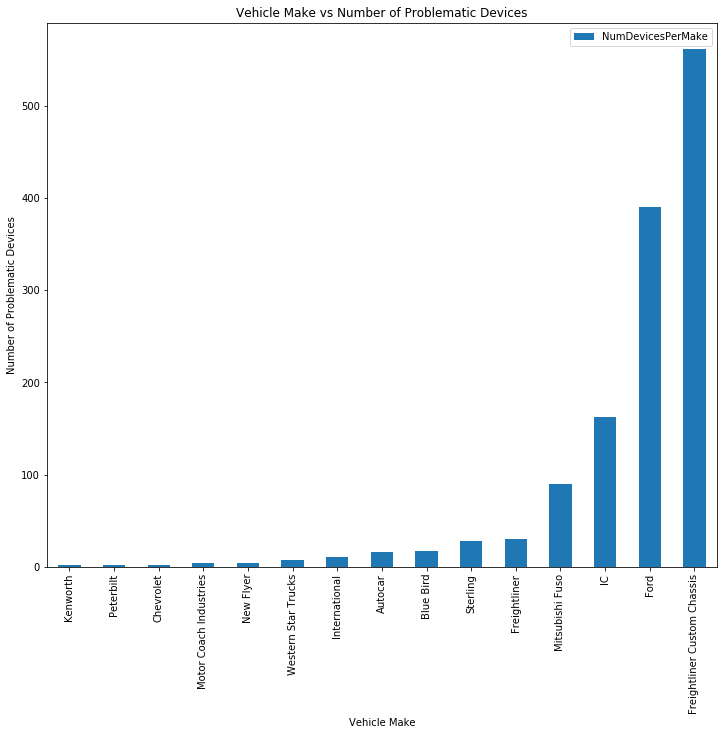

In [0]:
ax = df_device_per_make.plot.bar(x='Make', y='NumDevicesPerMake', rot=0)
plt.xticks(rotation=90)
plt.title('Vehicle Make vs Number of Problematic Devices')
plt.xlabel('Vehicle Make')
plt.ylabel('Number of Problematic Devices')

### Number of Bad Events per Make





In [0]:
SQL = '''
CREATE TEMP FUNCTION f_GeohashEncode(lat FLOAT64, lon FLOAT64, precision INT64)
            RETURNS STRING
           LANGUAGE js AS "return Geohash.encode(lat, lon, precision);"
            OPTIONS (library="gs://geotab-udfs/bi_geohash.js");

with t_pull_temps as (
   select ti.HardwareId, vd.Make, vd.Model, vd.Year, vd.Engine
        , ti.DateTime, ti.Latitude, ti.Longitude, ti.Temperature, vh.Vin, DATETIME_TRUNC(cast (DateTime as DATETIME), Day) as Day
     from (select HardwareId, Datetime, Latitude, Longitude, Value as Temperature
             from `geotab-bigdata.InterpolatedData.Status`
            where code = 53 and _partitiontime > '2019-05-01') ti 
     left outer join `geotab-bigdata.Vin.VinHistory` vh
       on vh.HardwareId = ti.HardwareId
      and (ti.DateTime between vh.DateFrom and vh.DateTo or (ti.DateTime >= vh.DateFrom and vh.DateTo is null))
     left outer join `geotab-bigdata.Vin.VinDecode` vd
       on vh.Vin = vd.Vin 
)
, data as (
    select Day, Make, Model, Year, Engine
        , min(Temperature) as MinTemperature
        , max(Temperature) as MaxTemperature
        , count(1) as NumRecords
        , array_agg(distinct HardwareId) as Devices
        , count(distinct HardwareId) as NumDevices
     from t_pull_temps
    group by Day, Make, Model, Year, Engine
    having  MinTemperature = MaxTemperature and NumDevices > 1 and NumRecords > 1 
)

select Make, sum(NumRecords) as NumBadRecordsPerMake
  from data 
 group by Make
having NumBadRecordsPerMake > 10 
 order by NumBadRecordsPerMake
 
 ''' 
df_new = client.query(SQL).to_dataframe()

In [0]:
df_new.tail()

,Make,NumBadRecordsPerMake
24,IC,32992
25,Autocar,39523
26,International,137471
27,Ford,196337
28,Freightliner Custom Chassis,250340


Text(0, 0.5, 'Number of Bad Data Events')

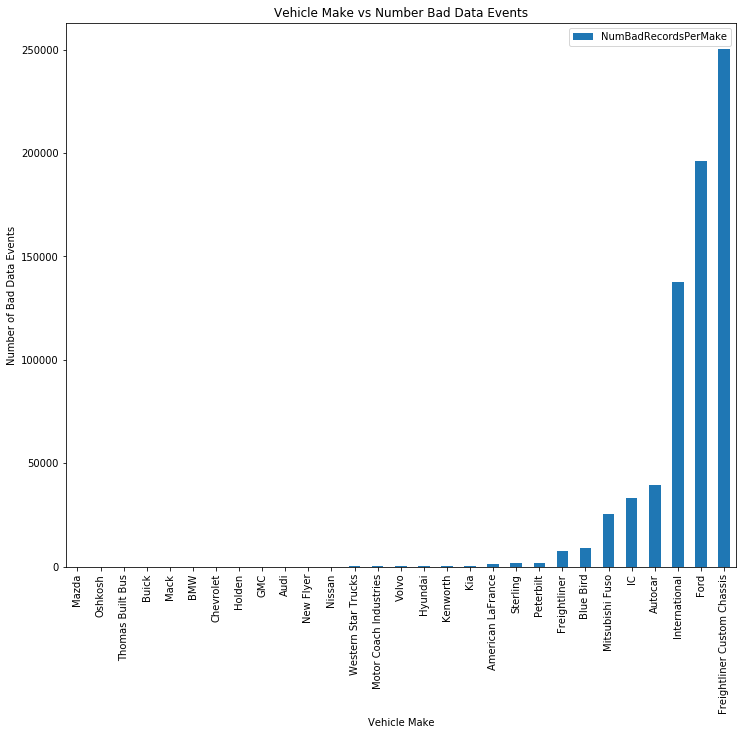

In [0]:
ax = df_new.plot.bar(x='Make', y='NumBadRecordsPerMake', rot=0)
plt.xticks(rotation=90)
plt.title('Vehicle Make vs Number Bad Data Events')
plt.xlabel('Vehicle Make')
plt.ylabel('Number of Bad Data Events')

NOTE: 'Bad Data Events' are defined as events where MinTemperature = MaxTemperature despite there being multiple devices and many temperature records. 






### Breakdown of specific voltage values and frequency 

In [0]:
SQL = '''
CREATE TEMP FUNCTION f_GeohashEncode(lat FLOAT64, lon FLOAT64, precision INT64)
            RETURNS STRING
           LANGUAGE js AS "return Geohash.encode(lat, lon, precision);"
            OPTIONS (library="gs://geotab-udfs/bi_geohash.js");

with t_pull_temps as (
   select ti.HardwareId, vd.Make, vd.Model, vd.Year, vd.Engine
        , ti.DateTime, ti.Latitude, ti.Longitude, ti.Temperature, vh.Vin, DATETIME_TRUNC(cast (DateTime as DATETIME), Day) as Day
--      from `geotab-bi.Staging_Weather.TestTemperatureStatusRollingWindow` ti
     from (select HardwareId, Datetime, Latitude, Longitude, Value as Temperature
             from `geotab-bigdata.InterpolatedData.Status`
            where code = 53 and _partitiontime > '2019-01-01') ti 
     left outer join `geotab-bigdata.Vin.VinHistory` vh
       on vh.HardwareId = ti.HardwareId
      and (ti.DateTime between vh.DateFrom and vh.DateTo or (ti.DateTime >= vh.DateFrom and vh.DateTo is null))
     left outer join `geotab-bigdata.Vin.VinDecode` vd
       on vh.Vin = vd.Vin 
)
, data as (
    select Make, Model, Year, Engine
--         , avg(Temperature) as AvgTemperature
        , min(Temperature) as MinTemperature
        , max(Temperature) as MaxTemperature
        , count(1) as NumRecords
        , array_agg(distinct HardwareId) as Devices
        , count(distinct HardwareId) as NumDevices
     from t_pull_temps
    group by Make, Model, Year, Engine
    having  MinTemperature = MaxTemperature and NumDevices > 1 and NumRecords > 1 
) 
select MinTemperature as Temp, sum(NumRecords) as NumBadRecordsPerMake 
  from data 
 group by Temp
 order by Temp
'''
df_values = client.query(SQL).to_dataframe()

In [0]:
df_values.head()

,Temp,NumBadRecordsPerMake
0,-40.0,131148
1,-36.0,59
2,-18.0,441
3,-17.0,196
4,-16.0,40


Text(0, 0.5, 'Number of Bad Data Records')

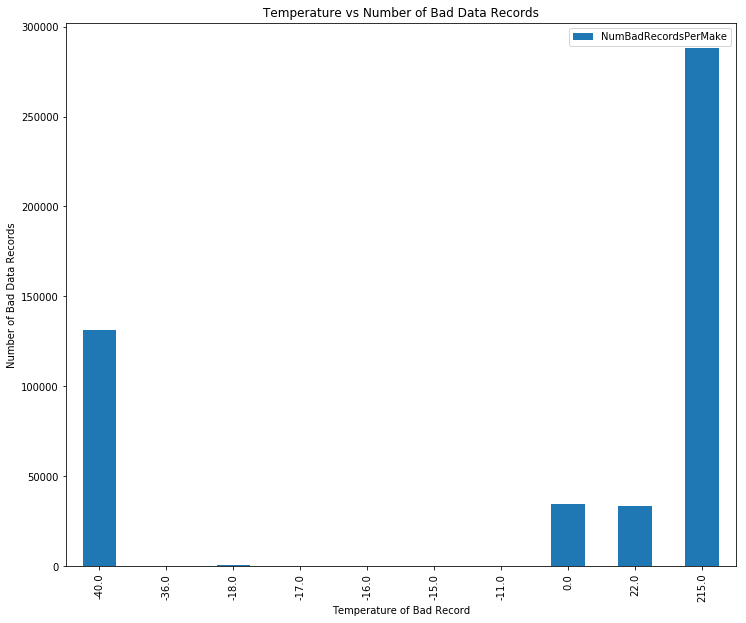

In [0]:
ax = df_values.plot.bar(x='Temp', y='NumBadRecordsPerMake', rot=0)
plt.xticks(rotation=90)
plt.title('Temperature vs Number of Bad Data Records')
plt.xlabel('Temperature of Bad Record')
plt.ylabel('Number of Bad Data Records')

There seems to be a lot of records returning 215 degrees Celcius, which is wrong because it is extremely high and both the Min and Max temperatures are the same. For other values (like -40 or 22), the value itself may not be wrong, but it is still only returning *one* value despite thousands of records. 

### Breakdown by Engine Type:  

In [0]:
SQL = '''
CREATE TEMP FUNCTION f_GeohashEncode(lat FLOAT64, lon FLOAT64, precision INT64)
            RETURNS STRING
           LANGUAGE js AS "return Geohash.encode(lat, lon, precision);"
            OPTIONS (library="gs://geotab-udfs/bi_geohash.js");

with t_pull_temps as (
   select ti.HardwareId, vd.Make, vd.Model, vd.Year, vd.Engine
        , ti.DateTime, ti.Latitude, ti.Longitude, ti.Temperature, vh.Vin, DATETIME_TRUNC(cast (DateTime as DATETIME), Day) as Day
     from (select HardwareId, Datetime, Latitude, Longitude, Value as Temperature
             from `geotab-bigdata.InterpolatedData.Status`
            where code = 53 and _partitiontime > '2019-05-01') ti 
     left outer join `geotab-bigdata.Vin.VinHistory` vh
       on vh.HardwareId = ti.HardwareId
      and (ti.DateTime between vh.DateFrom and vh.DateTo or (ti.DateTime >= vh.DateFrom and vh.DateTo is null))
     left outer join `geotab-bigdata.Vin.VinDecode` vd
       on vh.Vin = vd.Vin 
)
, data as (
    select Day, Make, Model, Year, Engine
        , min(Temperature) as MinTemperature
        , max(Temperature) as MaxTemperature
        , count(1) as NumRecords
        , array_agg(distinct HardwareId) as Devices
        , count(distinct HardwareId) as NumDevices
     from t_pull_temps
    group by Day, Make, Model, Year, Engine
    having  MinTemperature = MaxTemperature and NumDevices > 1 --and 551212594 in unnest(Devices) 
)

select Engine, count(*) as NumRepeat 
  from data 
 group by Engine
having NumRepeat > 10 
 order by NumRepeat
'''
df_engine = client.query(SQL).to_dataframe()

In [0]:
df_engine.tail()

,Engine,NumRepeat
28,10.8L I-6 Diesel Cummins,396
29,"915 CID Diesel Signature 600, ISX, AHD Cummins",399
30,660 CID Diesel ISM Cummins,408
31,"Cummins, ISL HPCR, Diesel, 6 Cyl., 8.9L",428
32,5.9L I-6 Diesel Cummins ISB,712


It's worth noting that **Diesel engines** are predominantly affected which indicates that this issue likely stems from a firmware issue with decoding data from diesel engines.

Additionally, if a certain Vin is found to have this problem, there is no instance of that Vin ever *not* having that problem. It persists until 2018-01-01, which is as far back as the data currently goes. 

However, if a certain HardwareId is found to have this problem, there are some instances where it may not have this problem, *depending on the Vin it is associated with*. This further confirms the hypothesis that this issue stems from an inability to properly decode the data from certain diesel engines. 

### Breakdown by Year 

In [0]:
SQL = '''
CREATE TEMP FUNCTION f_GeohashEncode(lat FLOAT64, lon FLOAT64, precision INT64)
            RETURNS STRING
           LANGUAGE js AS "return Geohash.encode(lat, lon, precision);"
            OPTIONS (library="gs://geotab-udfs/bi_geohash.js");

with t_pull_temps as (
   select ti.HardwareId, vd.Make, vd.Model, vd.Year, vd.Engine
        , ti.DateTime, ti.Latitude, ti.Longitude, ti.Temperature, vh.Vin, DATETIME_TRUNC(cast (DateTime as DATETIME), Day) as Day
     from (select HardwareId, Datetime, Latitude, Longitude, Value as Temperature
             from `geotab-bigdata.InterpolatedData.Status`
            where code = 53 and _partitiontime > '2019-05-01') ti 
     left outer join `geotab-bigdata.Vin.VinHistory` vh
       on vh.HardwareId = ti.HardwareId
      and (ti.DateTime between vh.DateFrom and vh.DateTo or (ti.DateTime >= vh.DateFrom and vh.DateTo is null))
     left outer join `geotab-bigdata.Vin.VinDecode` vd
       on vh.Vin = vd.Vin 
)
, data as (
    select Day, Make, Model, Year, Engine
        , min(Temperature) as MinTemperature
        , max(Temperature) as MaxTemperature
        , count(1) as NumRecords
        , array_agg(distinct HardwareId) as Devices
        , count(distinct HardwareId) as NumDevices
     from t_pull_temps
    group by Day, Make, Model, Year, Engine
    having  MinTemperature = MaxTemperature and NumDevices > 1 
)

select Year, sum(NumRecords) as NumBadRecordsPerMake 
  from data 
 group by Year
having NumBadRecordsPerMake > 10 
 order by Year
'''
df_year = client.query(SQL).to_dataframe()

In [0]:
df_year.tail()

,Year,NumBadRecordsPerMake
17,2016,5072
18,2017,581
19,2018,186
20,2019,66989
21,2020,57958


Text(0, 0.5, 'Number of Bad Data Events')

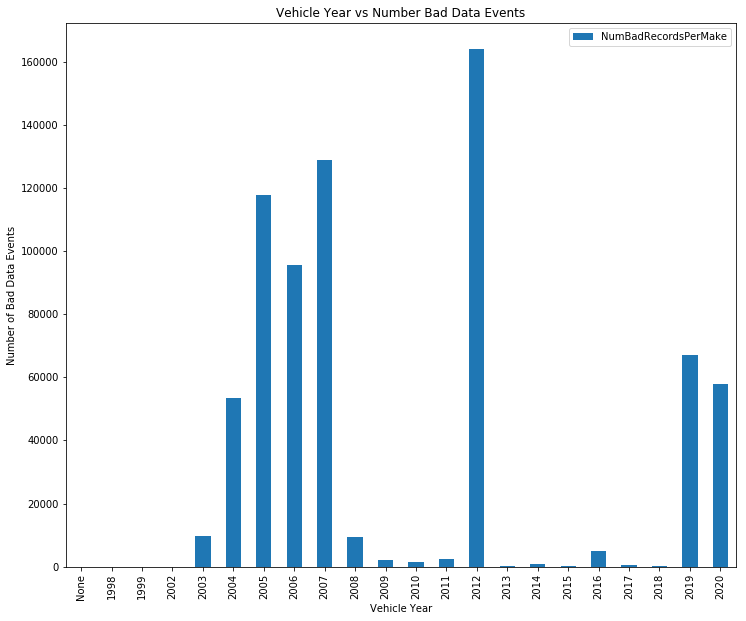

In [0]:
ax = df_year.plot.bar(x='Year', y='NumBadRecordsPerMake', rot=0)
plt.xticks(rotation=90)
plt.title('Vehicle Year vs Number Bad Data Events')
plt.xlabel('Vehicle Year')
plt.ylabel('Number of Bad Data Events')

The issue seems to affect certain years (2005-2007, 2012) disproportionaly more than later years. 

### List of All Problematic Devices: 

In [0]:
SQL = '''
CREATE TEMP FUNCTION f_GeohashEncode(lat FLOAT64, lon FLOAT64, precision INT64)
            RETURNS STRING
           LANGUAGE js AS "return Geohash.encode(lat, lon, precision);"
            OPTIONS (library="gs://geotab-udfs/bi_geohash.js");

with t_pull_temps as (
   select ti.HardwareId, vd.Make, vd.Model, vd.Year, vd.Engine
        , ti.DateTime, ti.Latitude, ti.Longitude, ti.Temperature, vh.Vin, DATETIME_TRUNC(cast (DateTime as DATETIME), Day) as Day
     from (select HardwareId, Datetime, Latitude, Longitude, Value as Temperature
             from `geotab-bigdata.InterpolatedData.Status`
            where code = 53 and _partitiontime = '2019-01-01') ti 
     left outer join `geotab-bigdata.Vin.VinHistory` vh
       on vh.HardwareId = ti.HardwareId
      and (ti.DateTime between vh.DateFrom and vh.DateTo or (ti.DateTime >= vh.DateFrom and vh.DateTo is null))
     left outer join `geotab-bigdata.Vin.VinDecode` vd
       on vh.Vin = vd.Vin 
)
, data as (
    select Make, Model, Year, Engine
        , min(Temperature) as MinTemperature
        , max(Temperature) as MaxTemperature
        , count(1) as NumRecords
        , array_agg(distinct HardwareId) as Devices
        , count(distinct HardwareId) as NumDevices
     from t_pull_temps
    group by Make, Model, Year, Engine
    having  MinTemperature = MaxTemperature and NumDevices > 1 and NumRecords > 1 
)
select distinct Problematic_HardwareId
  from data 
 cross join unnest(Devices) as Problematic_HardwareId 
 order by Problematic_HardwareId
'''

In [0]:
df_devices = client.query(SQL).to_dataframe()

In [0]:
df_devices.head()

,Problematic_HardwareId
0,550201090
1,550201108
2,550201335
3,550201349
4,550201396
